In [1]:
import requests
import pandas as pd
import os
import glob
from datetime import datetime
#from get_hdb_data import get_hdb_metadata_from_api, load_hdb_data_from_csv
#from preprocessing_hdb_data import preprocessing_hdb_dataframe
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns


Data Preparation

In [2]:
def filter_data_for_modeling(clean_hdb_df, year_cutoff=2013):
    #defining features and target variable
    feature_df = pd.DataFrame({
   # "resale_date": clean_hdb_df["month"],
    "transaction_id": clean_hdb_df["transaction_id"],
    "resale_year": clean_hdb_df["month"].dt.year,
    "town": clean_hdb_df["town"],
    "flat_age": (clean_hdb_df["month"] - clean_hdb_df["lease_commence_date"]).dt.days / 365.25,
    "flat_type": clean_hdb_df["flat_type"],
    })
    #target_variable =pd.DataFrame({"resale_price": clean_hdb_df["resale_price"]})

    #spliting data into past and future based on year cutoff
    #features with ID
    past_feature_df=feature_df[feature_df["resale_year"] <= year_cutoff]
    future_feature_df=feature_df[feature_df["resale_year"] > year_cutoff]

    #targets with id
    past_target_df = clean_hdb_df[clean_hdb_df["month"].dt.year <= year_cutoff][["transaction_id","resale_price"]]
    future_target_df = clean_hdb_df[clean_hdb_df["month"].dt.year > year_cutoff][["transaction_id","resale_price"]]
    
    return past_feature_df, past_target_df, future_feature_df, future_target_df


    

Load Data

In [3]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

In [4]:
clean_hdb_df1.dtypes

remaining_lease                float64
floor_area_sqm                 float64
storey_range                    object
street_name                     object
lease_commence_date     datetime64[ns]
month                   datetime64[ns]
flat_type                       object
resale_price                   float64
town                            object
block                           object
flat_model                      object
storey_range_min                 int64
storey_range_max                 int64
full_address                    object
Latitude                       float64
Longitude                      float64
nearest_mrt_id                  object
mrt_name                        object
mrt_latitude                   float64
mrt_longitude                  float64
mrt_road                        object
Distance_from_MRT_km           float64
transaction_id                   int64
dtype: object

In [13]:
# Extract the year from the 'month' column
df = clean_hdb_df1.copy()
df["year"] = df["month"].dt.year

# Combine specific years into one group
df["year_group"] = df["year"].astype(str)

# --- Create 4-year bins automatically from 1990 to 2025 ---
start_year = 1990
end_year = 2025
bin_edges = list(range(start_year, end_year + 1, 4))  # 4-year intervals
if bin_edges[-1] < end_year:
    bin_edges.append(end_year + 1)  # include final edge if not exact multiple

# Create readable labels like "1990–1993", "1994–1997", etc.
bin_labels = [f"{y}–{y+3}" for y in bin_edges[:-1]]

# Assign bins to dataframe
df["year_group"] = pd.cut(df["year"], bins=bin_edges, labels=bin_labels, right=False)


In [25]:
# --- Ensure year_group is ordered chronologically ---
# Convert to an ordered categorical type (if not already)
year_groups_sorted = sorted(df["year_group"].dropna().unique(), key=lambda x: int(str(x).split("–")[0]))
df["year_group"] = pd.Categorical(df["year_group"], categories=year_groups_sorted, ordered=True)


In [27]:
df["year_group"]

0         2014–2017
1         2014–2017
2         2014–2017
3         2014–2017
4         2014–2017
            ...    
962941    2010–2013
962942    2010–2013
962943    2010–2013
962944    2010–2013
962945    2010–2013
Name: year_group, Length: 962946, dtype: category
Categories (9, object): ['1990–1993' < '1994–1997' < '1998–2001' < '2002–2005' ... '2010–2013' < '2014–2017' < '2018–2021' < '2022–2025']

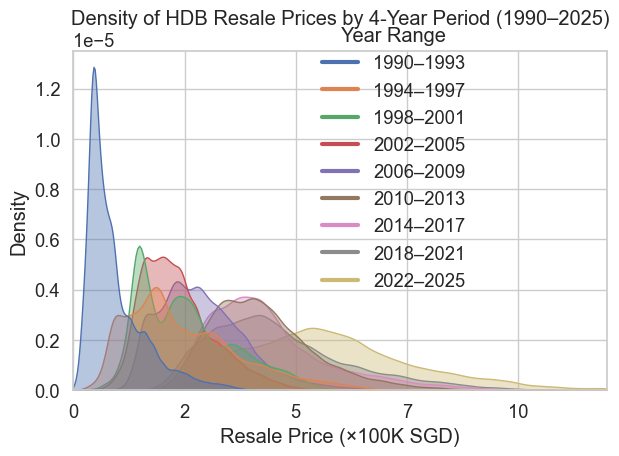

In [31]:
# --- Plot KDE ---
ax = sns.kdeplot(
    data=df,
    x="resale_price",
    hue="year_group",
    common_norm=False,
    fill=True,
    alpha=0.4,
    legend=True
)

# Format x-axis in 100K
xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{int(x/100_000)}" for x in xticks])
plt.xlim(0, 1200000)
plt.title("Density of HDB Resale Prices by 4-Year Period (1990–2025)")
plt.xlabel("Resale Price (×100K SGD)")
plt.ylabel("Density")

# --- Build ordered legend ---
handles, labels = ax.get_legend_handles_labels()

# If legend missing, rebuild manually (robust fallback)
if not labels or all("year_group" in l for l in labels):
    palette = sns.color_palette(n_colors=len(year_groups_sorted))
    handles = [
        plt.Line2D([0], [0], color=palette[i], lw=3, label=str(year_groups_sorted[i]))
        for i in range(len(year_groups_sorted))
    ]
    labels = [str(g) for g in year_groups_sorted]

# Place legend at top, sorted chronologically
plt.legend(
    handles=handles,
    labels=labels,
    title="Year Range",
    loc="upper center",
    bbox_to_anchor=(0.6, 1.12),
    ncol=min(len(labels), 1),
    frameon=False
)

plt.tight_layout()
plt.show()

Filtered Data required for model

In [5]:
past_feature_df, past_target_df, future_feature_df, future_target_df = filter_data_for_modeling(clean_hdb_df1, year_cutoff=2013)

In [6]:
print(len(past_feature_df))
print(len(past_target_df))
print(len(future_feature_df))
print(len(future_target_df))

692954
692954
269992
269992


In [7]:
past_feature_df.columns

Index(['transaction_id', 'resale_year', 'town', 'flat_age', 'flat_type'], dtype='object')

Prepare features for modeling

In [8]:
def prepare_features_sm(df, training_columns=None, drop_first=True):
    """
    Prepare features for training or prediction
    
    Parameters:
    -----------
    df : DataFrame with features
    training_columns : list, optional. If provided, align to these columns
    drop_first : bool, whether to drop first dummy variable
    
    Returns:
    --------
    X : numpy array ready for statsmodels
    columns : list of column names (for training phase)
    """
    # Extract and save IDs before processing
    ids = df["transaction_id"].copy() if "transaction_id" in df.columns else None

    # Drop ID column from features (not used in modeling)
    feature_cols = [col for col in df.columns if col != "transaction_id"]
    df_features = df[feature_cols].copy()

    # Get dummies: one-hot encoding for categorical variables
    #drop_first drops the first dummy column for each categorical variable. This prevents redundancy because one category can be inferred from the others.
    X_dummies = pd.get_dummies(df_features, drop_first=drop_first)
    
    # If training_columns provided, align to them. This ensures same feature set during prediction.
    if training_columns is not None:
        X_dummies = X_dummies.reindex(columns=training_columns, fill_value=0)
    
    # Convert to numpy and add constant
    #X_np = X_dummies.to_numpy()
    #X = sm.add_constant(X_np)
    #X = X.astype(float)
    
    return X_dummies, X_dummies.columns.tolist(), ids

Executing StatsModel

In [9]:

def apply_model_sm(X_train, Y_train):
    """
    Fit OLS regression model using statsmodels.
    
    Parameters:
    -----------
    X_train : DataFrame of training features
    Y_train : DataFrame of training target
    training_columns : list of column names (for reference)
    
    Returns:
    --------
    results_model1_sm : fitted model results
    """

    # Convert to numpy and add constant
    X_np = X_train.to_numpy()
    X = sm.add_constant(X_np) # Add intercept
    X = X.astype(float) #needed for statsmodels
    # Fit the ordinary least squares regression model

    Y=Y_train.to_numpy() 
    Y=Y.astype(float)

    model1_sm = sm.OLS(Y, X)
    results_model1_sm = model1_sm.fit()
    # Print the summary of regression results

    print(f"R2: {results_model1_sm.rsquared:.4f}")
    print(f"Result summary: {results_model1_sm.summary()}" )

    return results_model1_sm


Model Training

In [10]:
# TRAINING Data
X_train, training_columns, train_ids = prepare_features_sm(past_feature_df)
Y_train=past_target_df['resale_price']

# Verify alignment of IDs and target
assert len(train_ids) == len(Y_train), "ID and target length mismatch!"

results_model1_sm=apply_model_sm(X_train, Y_train)

R2: 0.7516
Result summary:                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                 6.167e+04
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:05:45   Log-Likelihood:            -8.6716e+06
No. Observations:              692954   AIC:                         1.734e+07
Df Residuals:                  692919   BIC:                         1.734e+07
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.477e+07   3

Testing the model 

In [14]:
# 2. Test Phase- CRITICAL: Must match training columns exactly

X_future_dummies, _ , future_ids= prepare_features_sm(future_feature_df, training_columns=training_columns)

Prediction using trained model

In [15]:
#Model specific preparation for prediction
X_future_np = X_future_dummies.to_numpy()
X_future = sm.add_constant(X_future_np)
X_future = X_future.astype(float)

# Make predictions
predictions = results_model1_sm.predict(X_future)
print("Done with predictions.")

Done with predictions.


Validations

In [16]:
# Safety check: Verify IDs match before using .values
assert (future_feature_df['transaction_id'].values == future_target_df['transaction_id'].values).all(), \
    "Feature and target IDs don't match! Use ID-based merging instead."

In [17]:

# Create results with IDs from both feature and target DataFrames
results_df = pd.DataFrame({
    'transaction_id': future_ids,  # From features
    'actual_price': future_target_df['resale_price'].values,  # From target
    'predicted_price': predictions,
    'error': future_target_df['resale_price'].values - predictions,
    'abs_error': abs(future_target_df['resale_price'].values - predictions),
    'pct_error': 100 * abs(future_target_df['resale_price'].values - predictions) / future_target_df['resale_price'].values
})

print("\nPrediction Results:")
print(results_df.head(5))
print(f"\nMean Absolute Error: ${results_df['abs_error'].mean():,.2f}")
print(f"Mean % Error: {results_df['pct_error'].mean():.2f}%")
print(f"RMSE: ${np.sqrt((results_df['error']**2).mean()):,.2f}")#


Prediction Results:
   transaction_id  actual_price  predicted_price         error     abs_error  \
0               1      232000.0    272136.781828 -40136.781828  40136.781828   
1               2      250000.0    339598.942067 -89598.942067  89598.942067   
2               3      262000.0    344209.114690 -82209.114690  82209.114690   
3               4      265000.0    344209.114690 -79209.114690  79209.114690   
4               5      265000.0    344209.114690 -79209.114690  79209.114690   

   pct_error  
0  17.300337  
1  35.839577  
2  31.377525  
3  29.890232  
4  29.890232  

Mean Absolute Error: $79,441.62
Mean % Error: 14.71%
RMSE: $115,786.07


Visualize the predictions vs actuals

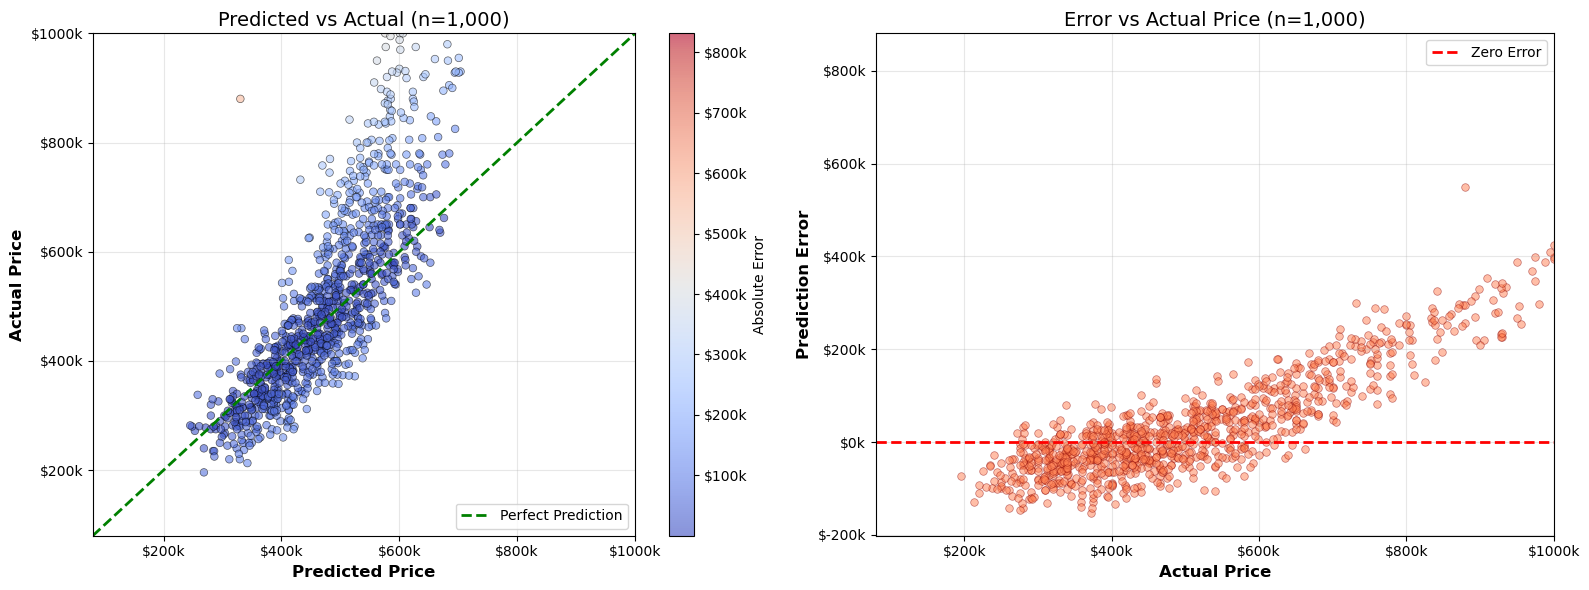

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sample
n = 1000
sample_df = results_df.sample(n=n, random_state=42)

# 1. Predicted vs Actual (color by error)
ax = axes[0]
scatter = ax.scatter(
    sample_df['predicted_price'], 
    sample_df['actual_price'], 
    c=sample_df['abs_error'],
    cmap='coolwarm',
    alpha=0.6, 
    s=30,
    edgecolors='black', 
    linewidth=0.5
)
x = np.linspace(80000, 1000000, 100)
ax.plot(x, x, 'g--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel("Predicted Price", fontsize=12, fontweight='bold')
ax.set_ylabel("Actual Price", fontsize=12, fontweight='bold')
ax.set_title(f"Predicted vs Actual (n={n:,})", fontsize=14)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))
ax.grid(True, alpha=0.3)
ax.set_xlim(80000, 1000000)
ax.set_ylim(80000, 1000000)
ax.legend(loc='lower right')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=10)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))

# 2. Error vs Actual Price
ax = axes[1]
ax.scatter(sample_df['actual_price'], sample_df['error'], alpha=0.5, s=30, c='coral', edgecolors='darkred', linewidth=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xlabel("Actual Price", fontsize=12, fontweight='bold')
ax.set_ylabel("Prediction Error", fontsize=12, fontweight='bold')
ax.set_title(f"Error vs Actual Price (n={n:,})", fontsize=14)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))
ax.grid(True, alpha=0.3)
ax.set_xlim(80000, 1000000)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

New Predictions

In [ ]:
def predict_resale_price(model_results, training_columns,actual_df, flat_type, town, flat_age, resale_year=2014):
    """
    Predict resale price for a specific flat
    
    Parameters:
    -----------
    model_results : statsmodels results object
    training_columns : list of column names from training
    flat_type : str, e.g., '3 ROOM', '4 ROOM', '5 ROOM'
    town : str, e.g., 'ANG MO KIO', 'BEDOK'
    flat_age : float, age of flat in years
    resale_year : int, year of resale
    
    Returns:
    --------
    predicted_price : float
    """
    
    # Create input dataframe
    input_df = pd.DataFrame({
        #'transaction_id': [0],  # Dummy ID
        'resale_year': [resale_year],
        'town': [town],
        'flat_age': [flat_age],
        'flat_type': [flat_type]
    })
    print(input_df.shape)
    
    # Prepare features (same way as training)
    X_input_dummies, _, _ = prepare_features_sm(
        input_df, 
        training_columns=training_columns
        #id_column=None  # No ID needed for single prediction
    )

    #print(X_input_dummies.shape)
     
    X_input_np = X_input_dummies.to_numpy()
    #X_input = sm.add_constant(X_input_np) #this is somehow not working
    X_input = sm.add_constant(X_input_np, has_constant='add')
    X_input = X_input.astype(float)
    #print(X_input.shape)

    # Make prediction
    predicted_price = model_results.predict(X_input)
    #print("Model exog shape:", model_results.model.exog.shape)
    #print("Model exog names:", model_results.model.exog_names)


    # Find similar flats in actual data
    similar_flats = actual_df[
        (actual_df['flat_type'] == flat_type.upper()) &
        (actual_df['town'] == town.upper()) &
        (actual_df['flat_age'] >= flat_age - 5) &
        (actual_df['flat_age'] <= flat_age + 5) &
        (actual_df['resale_year'] == resale_year)
        #(actual_df['resale_year'] >= resale_year - 1) &
        #(actual_df['resale_year'] <= resale_year + 1)
    ]
    
    if len(similar_flats) > 0:
        print(f"\nSimilar Flats Found: {len(similar_flats)}")
        print(f"  Average Actual Price: ${similar_flats['resale_price'].mean():,.2f}")
        print(f"  Price Range: ${similar_flats['resale_price'].min():,.2f} - ${similar_flats['resale_price'].max():,.2f}")
        print(f"  Median: ${similar_flats['resale_price'].median():,.2f}")
    else:
        print("\nNo similar flats found in dataset")
    

    return predicted_price, similar_flats




In [30]:
# Example prediction
predicted_price, similar_flats = predict_resale_price(
    model_results=results_model1_sm,
    training_columns=training_columns,
    #id=None
    flat_type='4 ROOM',
    town='BEDOK',
    flat_age=25,
    resale_year=2014,
    actual_df=pd.merge(future_feature_df, future_target_df, on='transaction_id', how='inner')
)

print(f"\nPredicted Resale Price: {predicted_price[0]:.2f}")

(1, 4)
(1, 34)
(1, 35)

Similar Flats Found: 72
  Average Actual Price: $419,668.78
  Price Range: $360,000.00 - $598,000.00
  Median: $408,500.00

Predicted Resale Price: 225351.46
